### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import plotly.express as px

import copy
import seaborn as sns
import os
from scipy import stats
import datetime

import sqlite3 as sqlite
from sqlalchemy import create_engine
%matplotlib inline

In [2]:
data_path = '/mnt/d/lighthouse/Midterm_data/'

In [3]:
# 15927485 rows × 42
flights = pd.read_csv(data_path + 'flights.csv', header = 0, low_memory=False)
#flights_test =pd.read_csv(data_path + 'flights_test.csv', header = 0)

In [4]:
# making duplicate so we dont have to re-read large csv files
flights_clean = copy.deepcopy(flights)

In [49]:
flights.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime', 'no_name'],
      dtype='object')

## Nan

In [5]:
total = flights_clean.isnull().sum().sort_values(ascending = False)
percent = (flights_clean.isnull().sum()/flights_clean.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Percent'])

In [6]:
#missing_data.head(15)

In [7]:
# dropping columsn with 80% missing AND [origin_city_name, dest_city_name] since we have [orgin, dest]
# dropping [cancelled, diverted, flights, dup] since they only contain one value
cols_to_drop_nan = list(missing_data[missing_data['Percent'] > 0.8].index)
cols_to_drop_other = ['dep_delay','taxi_out','taxi_in', 'wheels_off', 'wheels_on', 'arr_time', 'cancelled', 'diverted','actual_elapsed_time','air_time', 'flights', 'dup', 'dep_time']
flights_clean.drop(cols_to_drop_nan, axis = 1, inplace = True)
flights_clean.drop(cols_to_drop_other, axis = 1, inplace = True)
#flights_test.drop(['dup','flights'], axis =1, inplace=True)

## rows with Nan

In [8]:
# before: (15927485, 20)
# after: 15652397 rows × 20 columns
# lost 3% of data, no biggie
flights_clean.dropna(inplace = True)

# before: (660556, 18)
# after: (659057, 18)
#flights_test.dropna(inplace = True)

In [9]:
# (15605076, 19)
flights_clean.shape

(15615740, 19)

### seperate numerical/categorical

In [14]:
# 9 numerical features
numerical = list(flights_clean.dtypes[flights_clean.dtypes != 'object'].index)
# 10 categorical features 
categorical = list(flights_clean.dtypes[flights_clean.dtypes == 'object'].index)

In [17]:
flights_numerical = copy.deepcopy(flights_clean[['crs_dep_time','crs_arr_time','arr_delay','crs_elapsed_time','distance']])
flights_categorical = copy.deepcopy(flights_clean.drop(['crs_dep_time','crs_arr_time','arr_delay','crs_elapsed_time','distance'], axis = 1))

In [20]:
flights_numerical

,crs_dep_time,crs_arr_time,arr_delay,crs_elapsed_time,distance
0,1755,1850,-12.0,175.0,1044
1,2000,2055,-19.0,175.0,1044
2,540,635,-10.0,175.0,1044
3,1550,1905,94.0,135.0,904
4,1045,1430,152.0,165.0,1155
...,...,...,...,...,...
15927480,2055,2245,-3.0,110.0,689
15927481,1200,1355,99.0,235.0,1489
15927482,920,1110,-18.0,230.0,1482
15927483,1125,1215,-11.0,170.0,1044


In [21]:
flights_numerical.to_csv('/mnt/d/lighthouse/Midterm_data/model_data_numerical.csv')
flights_categorical.to_csv('/mnt/d/lighthouse/Midterm_data/model_data_categorical.csv')

# Binning and dropping correlated columns

### seperate year-month-day (stopped doing for test set at this point)

In [22]:
flights_categorical['fl_date'] = pd.to_datetime(flights_categorical['fl_date'])
flights_categorical['year'] = flights_categorical['fl_date'].dt.year
flights_categorical['month'] = flights_categorical['fl_date'].dt.month
flights_categorical['date'] = flights_categorical['fl_date'].dt.day
# Dropping the old date column
flights_categorical.drop('fl_date', axis = 1, inplace = True)

### Dropping origin_city_name and dest_city_name

In [23]:
# dropping since origin and dest tells us the city
flights_categorical.drop(['origin_city_name', 'dest_city_name'],axis =1,inplace = True)

In [24]:
flights_categorical.shape

(15615740, 14)

In [25]:
flights_categorical.drop(['branded_code_share','mkt_carrier','op_unique_carrier'], axis = 1, inplace = True)

In [26]:
flights_categorical

,mkt_unique_carrier,mkt_carrier_fl_num,tail_num,op_carrier_fl_num,origin_airport_id,origin,dest_airport_id,dest,year,month,date
0,WN,2098,N8540V,2098,13198,MCI,14107,PHX,2019,3,25
1,WN,2238,N8656B,2238,13198,MCI,14107,PHX,2019,3,25
2,WN,2451,N8583Z,2451,13198,MCI,14107,PHX,2019,3,25
3,WN,2213,N737JW,2213,13198,MCI,14492,RDU,2019,3,25
4,WN,2096,N705SW,2096,13198,MCI,14635,RSW,2019,3,25
...,...,...,...,...,...,...,...,...,...,...,...
15927480,WN,2189,N7702A,2189,13198,MCI,13495,MSY,2019,3,25
15927481,WN,1291,N7878A,1291,13198,MCI,13796,OAK,2019,3,25
15927482,WN,2470,N760SW,2470,13198,MCI,14057,PDX,2019,3,25
15927483,WN,1651,N8542Z,1651,13198,MCI,14107,PHX,2019,3,25


### encode all string variables

In [27]:
# converting category to numbers
flights_categorical['mkt_unique_carrier'] = pd.factorize(flights_categorical['mkt_unique_carrier'])[0]
flights_categorical['tail_num'] = pd.factorize(flights_categorical['tail_num'])[0]
flights_categorical['origin'] = pd.factorize(flights_categorical['origin'])[0]
flights_categorical['dest'] = pd.factorize(flights_categorical['dest'])[0]

In [28]:
flights_categorical

,mkt_unique_carrier,mkt_carrier_fl_num,tail_num,op_carrier_fl_num,origin_airport_id,origin,dest_airport_id,dest,year,month,date
0,0,2098,0,2098,13198,0,14107,0,2019,3,25
1,0,2238,1,2238,13198,0,14107,0,2019,3,25
2,0,2451,2,2451,13198,0,14107,0,2019,3,25
3,0,2213,3,2213,13198,0,14492,1,2019,3,25
4,0,2096,4,2096,13198,0,14635,2,2019,3,25
...,...,...,...,...,...,...,...,...,...,...,...
15927480,0,2189,143,2189,13198,0,13495,30,2019,3,25
15927481,0,1291,197,1291,13198,0,13796,31,2019,3,25
15927482,0,2470,290,2470,13198,0,14057,58,2019,3,25
15927483,0,1651,293,1651,13198,0,14107,0,2019,3,25


### Standardize/scale numerical

In [ ]:
flights_numerical

In [67]:
flights_numerical.drop(['crs_elapsed_time','op_carrier_fl_num'], axis = 1, inplace= True)

In [73]:
numerical_var = flights_numerical[['crs_dep_time','crs_arr_time','arr_delay','distance']].values
num_scaled = StandardScaler().fit_transform(numerical_var)
num_scaled

array([[ 0.87097422,  0.70950578, -0.35040153,  0.46598272],
       [ 1.37134788,  1.10635953, -0.49075525,  0.46598272],
       [-1.61047067, -1.64257867, -0.31030047,  0.46598272],
       ...,
       [-0.83438091, -0.72303948, -0.47070472,  1.21186979],
       [-0.41570091, -0.51977293, -0.330351  ,  0.46598272],
       [ 0.04382592, -0.07452237, -0.330351  ,  0.46598272]])

In [75]:
flights_numerical['crs_dep_time'] = num_scaled[:,0]
flights_numerical['crs_arr_time'] = num_scaled[:,1]
flights_numerical['arr_delay'] = num_scaled[:,2]
flights_numerical['distance'] = num_scaled[:,3]

In [29]:
flights_categorical

,mkt_unique_carrier,mkt_carrier_fl_num,tail_num,op_carrier_fl_num,origin_airport_id,origin,dest_airport_id,dest,year,month,date
0,0,2098,0,2098,13198,0,14107,0,2019,3,25
1,0,2238,1,2238,13198,0,14107,0,2019,3,25
2,0,2451,2,2451,13198,0,14107,0,2019,3,25
3,0,2213,3,2213,13198,0,14492,1,2019,3,25
4,0,2096,4,2096,13198,0,14635,2,2019,3,25
...,...,...,...,...,...,...,...,...,...,...,...
15927480,0,2189,143,2189,13198,0,13495,30,2019,3,25
15927481,0,1291,197,1291,13198,0,13796,31,2019,3,25
15927482,0,2470,290,2470,13198,0,14057,58,2019,3,25
15927483,0,1651,293,1651,13198,0,14107,0,2019,3,25


In [30]:
flights_numerical

,crs_dep_time,crs_arr_time,arr_delay,crs_elapsed_time,distance
0,1755,1850,-12.0,175.0,1044
1,2000,2055,-19.0,175.0,1044
2,540,635,-10.0,175.0,1044
3,1550,1905,94.0,135.0,904
4,1045,1430,152.0,165.0,1155
...,...,...,...,...,...
15927480,2055,2245,-3.0,110.0,689
15927481,1200,1355,99.0,235.0,1489
15927482,920,1110,-18.0,230.0,1482
15927483,1125,1215,-11.0,170.0,1044


### merging into into model data

In [31]:
flights_final = pd.concat([flights_numerical, flights_categorical], axis=1)
flights_final.reset_index(drop=True)
flights_final

,crs_dep_time,crs_arr_time,arr_delay,crs_elapsed_time,distance,mkt_unique_carrier,mkt_carrier_fl_num,tail_num,op_carrier_fl_num,origin_airport_id,origin,dest_airport_id,dest,year,month,date
0,1755,1850,-12.0,175.0,1044,0,2098,0,2098,13198,0,14107,0,2019,3,25
1,2000,2055,-19.0,175.0,1044,0,2238,1,2238,13198,0,14107,0,2019,3,25
2,540,635,-10.0,175.0,1044,0,2451,2,2451,13198,0,14107,0,2019,3,25
3,1550,1905,94.0,135.0,904,0,2213,3,2213,13198,0,14492,1,2019,3,25
4,1045,1430,152.0,165.0,1155,0,2096,4,2096,13198,0,14635,2,2019,3,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15927480,2055,2245,-3.0,110.0,689,0,2189,143,2189,13198,0,13495,30,2019,3,25
15927481,1200,1355,99.0,235.0,1489,0,1291,197,1291,13198,0,13796,31,2019,3,25
15927482,920,1110,-18.0,230.0,1482,0,2470,290,2470,13198,0,14057,58,2019,3,25
15927483,1125,1215,-11.0,170.0,1044,0,1651,293,1651,13198,0,14107,0,2019,3,25


### Correlation

In [32]:
df_corr = flights_final.corr().abs()
indices = np.where(df_corr > 0.8) 
indices = [(df_corr.index[x], df_corr.columns[y]) for x, y in zip(*indices) if x != y and x < y]
indices

[('crs_elapsed_time', 'distance'), ('mkt_carrier_fl_num', 'op_carrier_fl_num')]

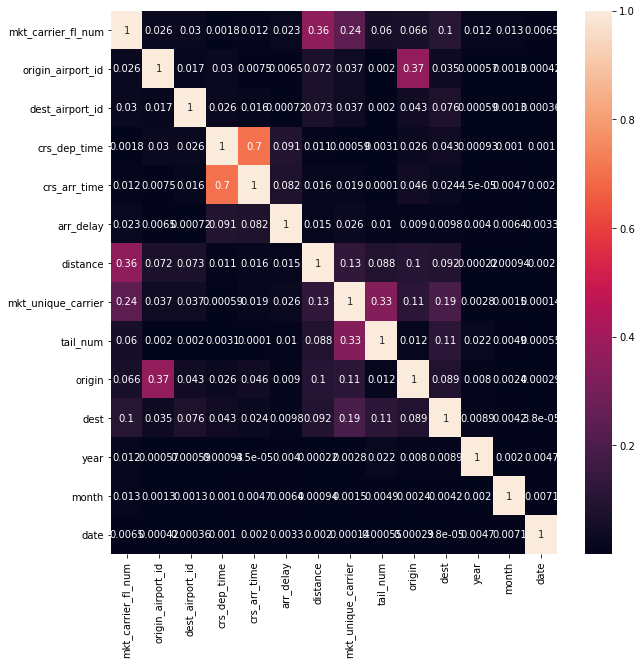

In [80]:
fig, ax = plt.subplots(figsize=(10,10))
corrMatrix = flights_final.corr().abs()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [12]:
# no highly correlated features
for idx in indices: 
    try:
        flights_final.drop(idx[1], axis = 1, inplace=True)
    except KeyError:
        pass

In [33]:
flights_final.drop(['crs_elapsed_time','op_carrier_fl_num'],axis = 1,inplace = True)

In [46]:
flights_numerical

,crs_dep_time,crs_arr_time,arr_delay,crs_elapsed_time,distance
0,1755,1850,-12.0,175.0,1044
1,2000,2055,-19.0,175.0,1044
2,540,635,-10.0,175.0,1044
3,1550,1905,94.0,135.0,904
4,1045,1430,152.0,165.0,1155
...,...,...,...,...,...
15927480,2055,2245,-3.0,110.0,689
15927481,1200,1355,99.0,235.0,1489
15927482,920,1110,-18.0,230.0,1482
15927483,1125,1215,-11.0,170.0,1044


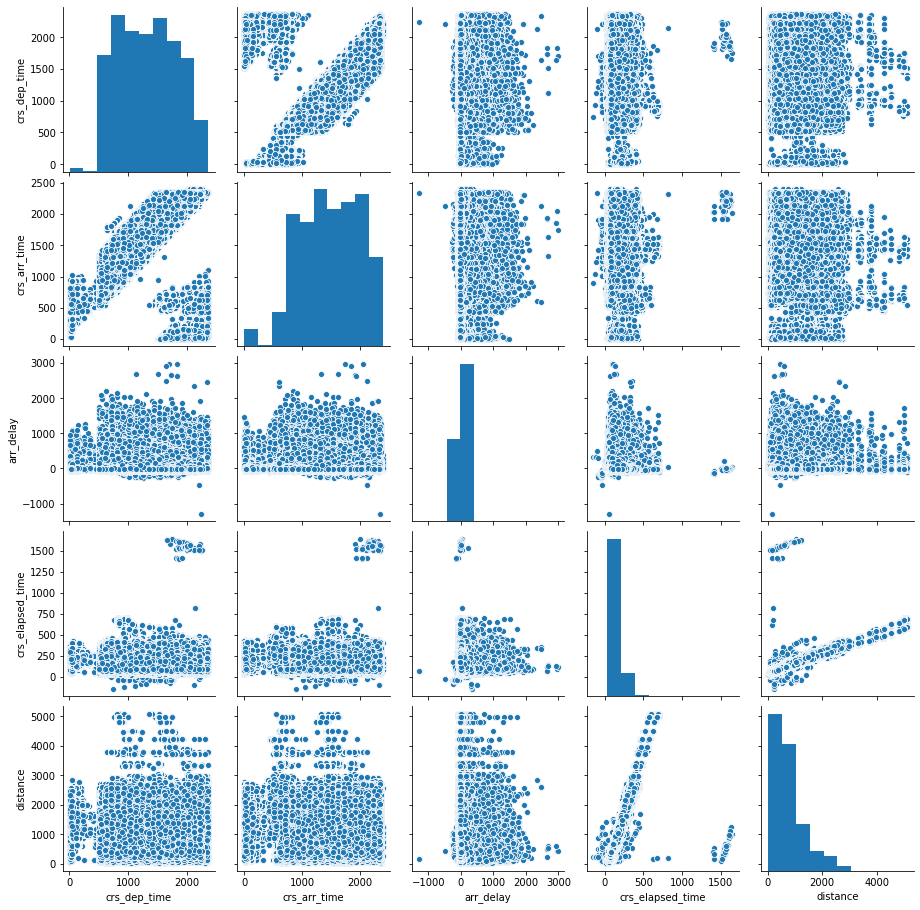

In [47]:
sns.pairplot(flights_numerical)

In [35]:
#flights_final.to_csv('/mnt/d/lighthouse/Midterm_data/model_3_unscaled.csv')

# Model

In [4]:
#flights_final = pd.read_csv(data_path + 'model_2_bin.csv', header = 0)
#flights_final.drop('Unnamed: 0', axis = 1, inplace= True)

In [36]:
flights_final

,crs_dep_time,crs_arr_time,arr_delay,distance,mkt_unique_carrier,mkt_carrier_fl_num,tail_num,origin_airport_id,origin,dest_airport_id,dest,year,month,date
0,1755,1850,-12.0,1044,0,2098,0,13198,0,14107,0,2019,3,25
1,2000,2055,-19.0,1044,0,2238,1,13198,0,14107,0,2019,3,25
2,540,635,-10.0,1044,0,2451,2,13198,0,14107,0,2019,3,25
3,1550,1905,94.0,904,0,2213,3,13198,0,14492,1,2019,3,25
4,1045,1430,152.0,1155,0,2096,4,13198,0,14635,2,2019,3,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15927480,2055,2245,-3.0,689,0,2189,143,13198,0,13495,30,2019,3,25
15927481,1200,1355,99.0,1489,0,1291,197,13198,0,13796,31,2019,3,25
15927482,920,1110,-18.0,1482,0,2470,290,13198,0,14057,58,2019,3,25
15927483,1125,1215,-11.0,1044,0,1651,293,13198,0,14107,0,2019,3,25


In [37]:
X = flights_final.drop('arr_delay', axis = 1)
y = flights_final['arr_delay']

In [38]:
X.shape

(15615740, 13)

In [39]:
y.shape

(15615740,)

### sklearn

In [40]:
reg = LinearRegression().fit(X, y)

In [41]:
reg.score(X, y)

0.010735862184142242

In [42]:
reg.coef_

array([ 6.77838496e-03,  3.45382205e-03, -7.42545846e-04,  8.08502815e-01,
        7.44280960e-04,  6.36495901e-05, -7.60515376e-05,  3.88092040e-03,
       -2.31578758e-05, -3.86081801e-03,  4.25041786e-01, -9.44734614e-02,
       -1.86211219e-02])

### Statsmodel

In [43]:
res = sm.OLS(y, X).fit()

In [44]:
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:              arr_delay   R-squared (uncentered):                   0.023
Model:                            OLS   Adj. R-squared (uncentered):              0.023
Method:                 Least Squares   F-statistic:                          2.765e+04
Date:                Wed, 26 Aug 2020   Prob (F-statistic):                        0.00
Time:                        18:00:53   Log-Likelihood:                     -8.3123e+07
No. Observations:            15615740   AIC:                                  1.662e+08
Df Residuals:                15615727   BIC:                                  1.662e+08
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------